In [92]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns

### Lectura, selección de columnas y conversión de datos

In [93]:
df = pd.read_csv('netflix_titles.csv')

##Cantidad de valores nulos

df.isna().sum().sort_values(ascending=False) ##La columna director tiene 2634 datos faltantes. Seguido de country y cast con 831 y 825 faltantes respectivamente.
df.isna().sum().sort_values(ascending=False)/df.shape[0]*100 ##Esto es equivalente a que el 29.9% de los datos de director son nulos.

##Remplazar los valores nulos con la moda
df['director'] = df['director'].fillna(df['director'].mode()[0])
df['cast'] = df['cast'].fillna(df['cast'].mode()[0])
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df['duration'] = df['duration'].fillna(df['duration'].mode()[0])

##Información básica del dataframe antes de la conversión
# df.info()   ##Todas las columnas tienen datos de tipo objeto (string) excepto el año de salida de la serie/película.

# ##Convertir el año de adición de la película/serie a DateTime
df['date_added'] = df['date_added'].str.strip() ##Primero se debe solucionar que algunos valores tienen espacios vaciós en medio
df['date_added'] = pd.to_datetime(df['date_added'],format = '%B %d, %Y')

# ##Verificar filas repetidas
df.duplicated().sum() #No hay filas repetidas

# ## Optimizar los datos de la columna release year
df = df.astype({'release_year':int})

# ##Eliminar columnas innecesarias
df.drop(columns=['description','show_id'],inplace=True)



### Estilos para los gráficos

In [94]:
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.family"]="serif"
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=16
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["axes.edgecolor"]="0.2"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False

### Identificar valores atípicos/Outliers

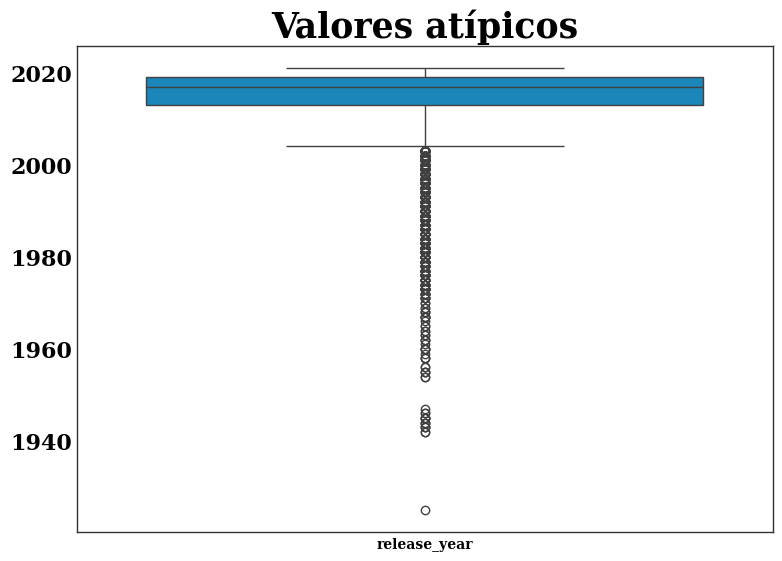

In [95]:
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=df,ax=ax)
ax.set_title('Valores atípicos')
plt.show()

##La columna de año de estreno tiene muchos valores por fuera del rango intercuartílico. Vamos a trabajar solo con valores dentro de un rango 1.5 veces el rango intercuartílico.

q1 = df['release_year'].quantile(0.25)
q3 = df['release_year'].quantile(0.75)

iqr = q3-q1
limite_inferior = q1 - 1.5*iqr
limite_superior = q3 + 1.5*iqr

df = df.loc[(df['release_year']>=limite_inferior)&(df['release_year']<=limite_superior)]


### Análisis exploratorio - Distribución de los datos

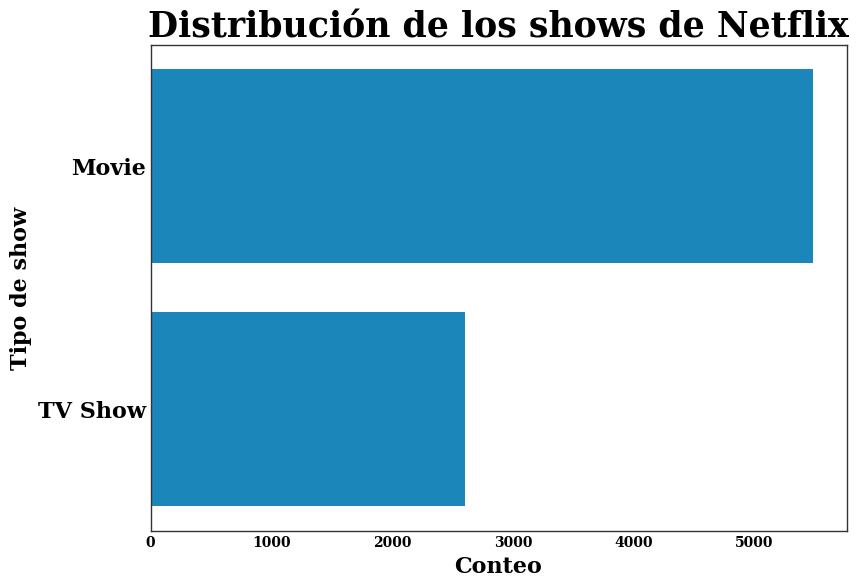

In [96]:
##Tipo de show

plt.figure(figsize=(8,6))

sns.countplot(data=df['type']).set_title('Distribución de los shows de Netflix')
plt.xlabel('Conteo')
plt.ylabel('Tipo de show')
plt.show()

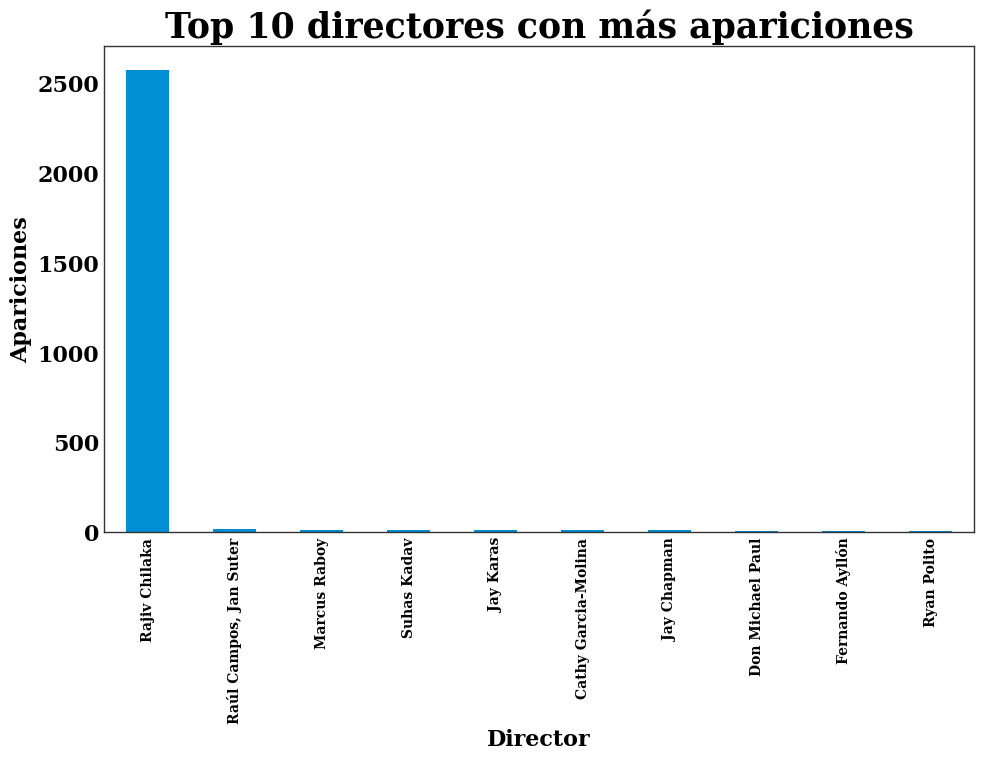

In [97]:
##Mejores directores
plt.figure(figsize=(10,6))
df['director'].value_counts(sort=True).head(10).plot.bar(title='Top 10 directores con más apariciones',xlabel='Director',ylabel='Apariciones')
plt.show()

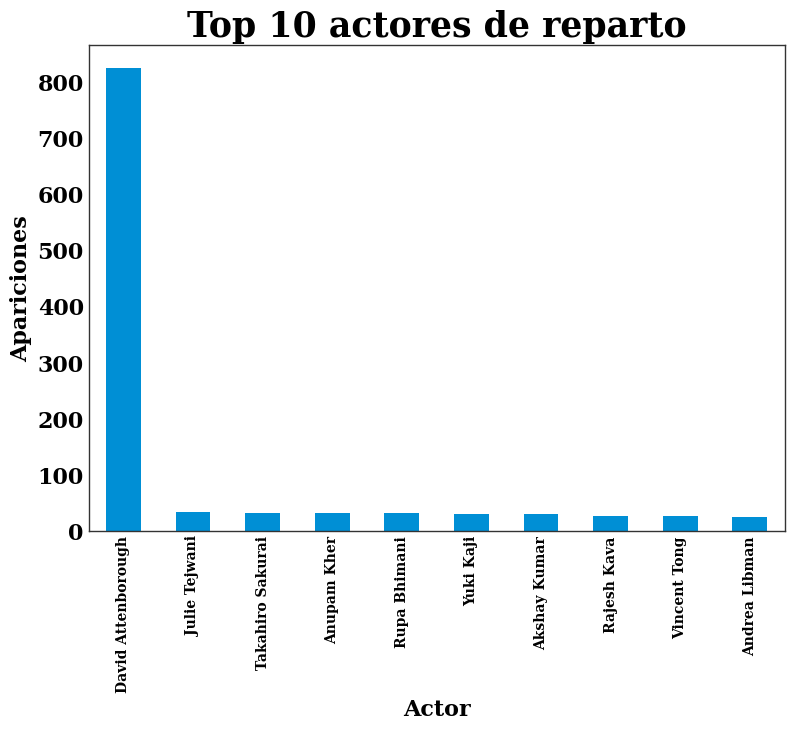

In [98]:
## Top actores del reparto

top_cast = df['cast'].str.split(', ',expand=True).stack().value_counts(sort=True).head(10)
plt.figure(figsize=(8,6))
top_cast.plot.bar(title='Top 10 actores de reparto',xlabel='Actor',ylabel='Apariciones')
plt.show()

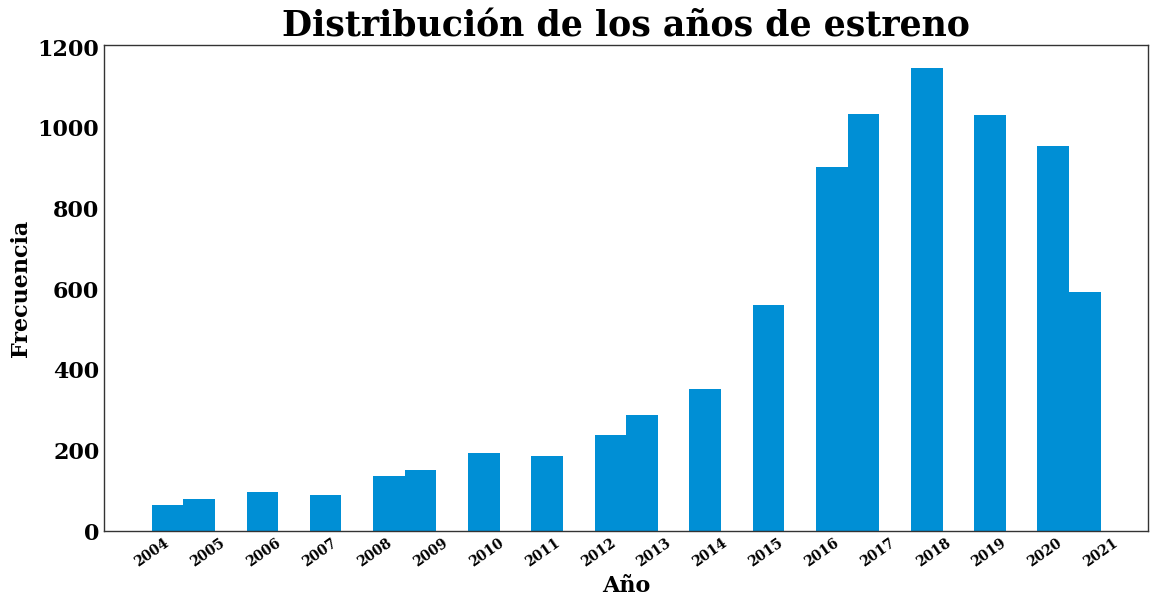

In [99]:
##año de estreno de los shows/películas
plt.figure(figsize=(12,6))

df['release_year'].plot(kind='hist',bins=30,title='Distribución de los años de estreno',xlabel='Año',ylabel='Frecuencia')
plt.xticks(sorted(df['release_year'].unique()))
plt.tick_params(rotation=35,axis='x')
plt.show()

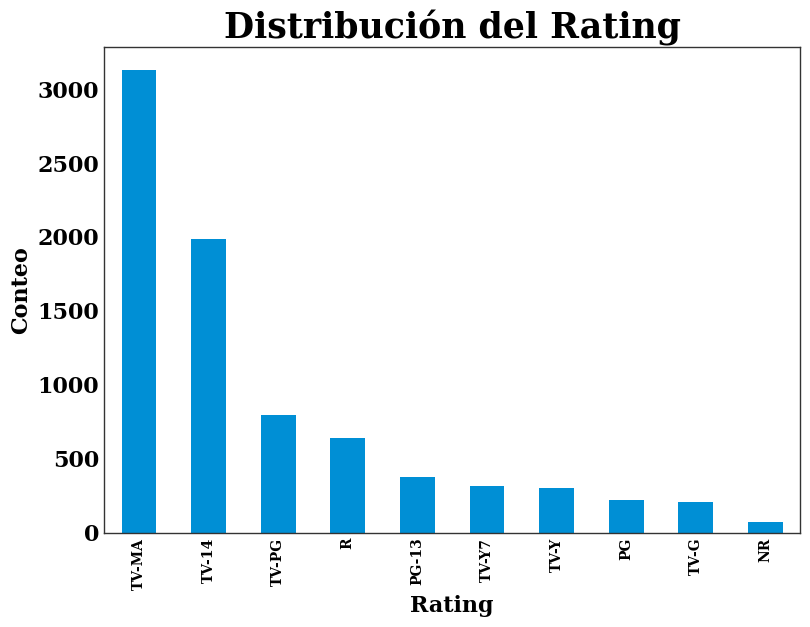

In [100]:
## Distribución de las calificaciones (Rating)

plt.figure(figsize=(8,6))
df['rating'].value_counts(sort=True).head(10).plot.bar(xlabel='Rating',title='Distribución del Rating',ylabel='Conteo')
plt.show()

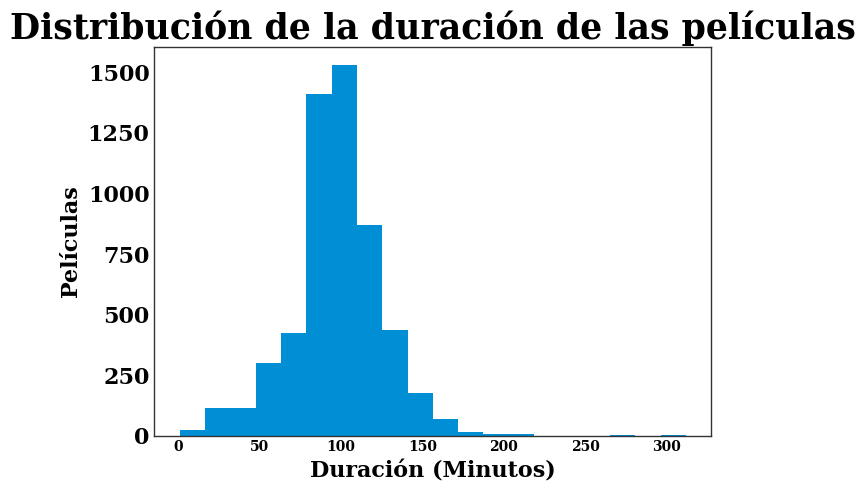

In [101]:
##Distribución de la duración de las películas
films = df.loc[df['type']=='Movie']
films = films['duration'].str.split(' ',expand=True).drop(columns=1).astype(int)

films[0].plot(kind='hist',bins=20,xlabel='Duración (Minutos)',ylabel='Películas',title='Distribución de la duración de las películas')
plt.show()

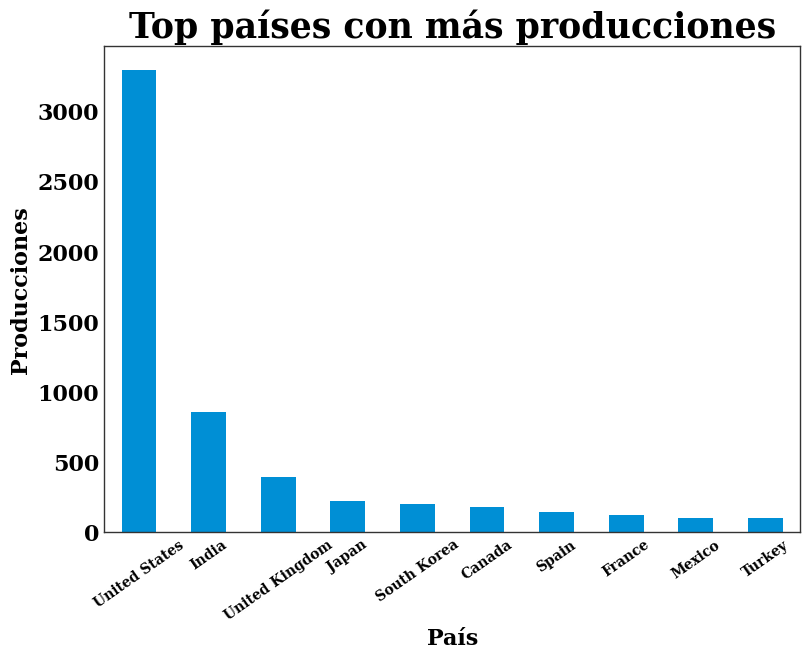

In [102]:
##Paises con más producciones

plt.figure(figsize=(8,6))
df['country'].value_counts(sort=True).head(10).plot.bar(xlabel='País',ylabel='Producciones',title='Top países con más producciones')
plt.tick_params(rotation=35, axis='x')
plt.show()

### Proceso de Machine Learning

In [103]:
##El objetivo es predecir qué influencia tiene la duración y el año de estreno d euna película en el rating de las películas.


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

##Paso 1: codificar las variables para que sean numéricas

variables_cat = df.select_dtypes('O')

label = LabelEncoder()

for col in variables_cat:
    df[col] = label.fit_transform(df[col].astype(str))


In [104]:
##Paso 2: entrenar el modelo y predecir

x = df[['duration','release_year']]
y = df['rating']

x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=252)

model = LinearRegression()
model.fit(x_train,y_train)

##Predecir

y_pred = model.predict(x_test)

Las métricas de evaluación del error del modelo son:
MSE: 3.50 - MAE: 1.48 - R2: 0.06


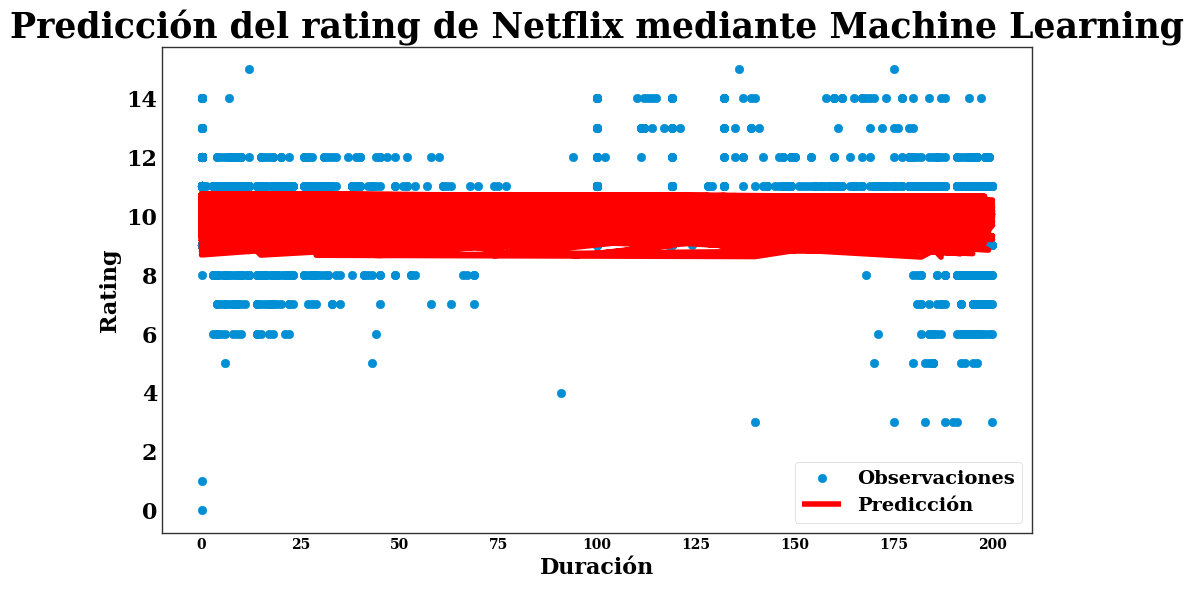

In [105]:
##Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)

print(f'Las métricas de evaluación del error del modelo son:\nMSE: {mse:.2f} - MAE: {mae:.2f} - R2: {r2:.2f}')

#Visualizar los resultados

plt.figure(figsize=(10,6))
plt.scatter(x_test['duration'],y_test,label='Observaciones')
plt.plot(x_test['duration'],y_pred, color='r',label='Predicción')
plt.xlabel('Duración')
plt.ylabel('Rating')
plt.title('Predicción del rating de Netflix mediante Machine Learning')
plt.legend()
plt.show()

## Conclusión

* El modelo de Machine Learning entrenado con los datos de Netflix fue capaz de predecir los puntajes del Rating con un R cuadrado de 0.06. Es decir, el modelo puede explicar aproximadamente el 6% de la variación de los valores del Rating. 
* El modelo sugiere que la duración y el año de estreno tienen un impacto significativo en el rating.
* La información podría ser de ayuda para Netflix en su selección de contenido y estrategias de Marketing para estimar el potencial de éxito de sus películas según la fecha de estreno